In [ ]:
!pip install transformers datasets torch torchvision torchaudio
!pip install scikit-learn matplotlib seaborn
!pip install accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 69.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 39.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 25.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 62.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [1]:
import pandas as pd
import numpy as np
from datasets import Dataset
from transformers import (
    AutoTokenizer, AutoModelForTokenClassification,
    TrainingArguments, Trainer, DataCollatorForTokenClassification
)
from sklearn.metrics import classification_report, accuracy_score
import torch
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [45]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

Using device: cuda
GPU: Tesla T4
GPU Memory: 14.7 GB


In [8]:
file_path = '/content/amharic_ner_conll_100 (1).txt'

# Verify file exists
import os
if os.path.exists(file_path):
    print("✅ File found successfully!")

    # Quick peek at the file
    with open(file_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()[:20]
        print(f"\nFirst 20 lines of your file:")
        for i, line in enumerate(lines):
            print(f"{i+1:2d}: {line.strip()}")
else:
    print("❌ File not found. Please check the file path.")


✅ File found successfully!

First 20 lines of your file:
 1: Nike_air B-Product
 2: # O
 3: Made O
 4: in O
 5: Vietnam O
 6: Size: O
 7: 40,41,42,43 O
 8: Price: B-PRICE
 9: 2,500 I-PRICE
10: Free O
11: Delivery O
12: በነፃ O
13: እናደርሳለን O
14: Address O
15: ቄራ B-LOC
16: ሶፊያ I-LOC
17: ሞል I-LOC
18: ሁለተኛ O
19: ፎቅ O
20: Contact O


🔍 Running Data Diagnostics...
Found 51 raw messages

✅ Loaded 51 sentences

📊 Label Distribution:
Total tokens: 540
Unique labels: 7
  O: 344 (63.7%)
  B-Product: 60 (11.1%)
  I-PRICE: 45 (8.3%)
  B-LOC: 38 (7.0%)
  I-Product: 24 (4.4%)
  B-PRICE: 23 (4.3%)
  I-LOC: 6 (1.1%)


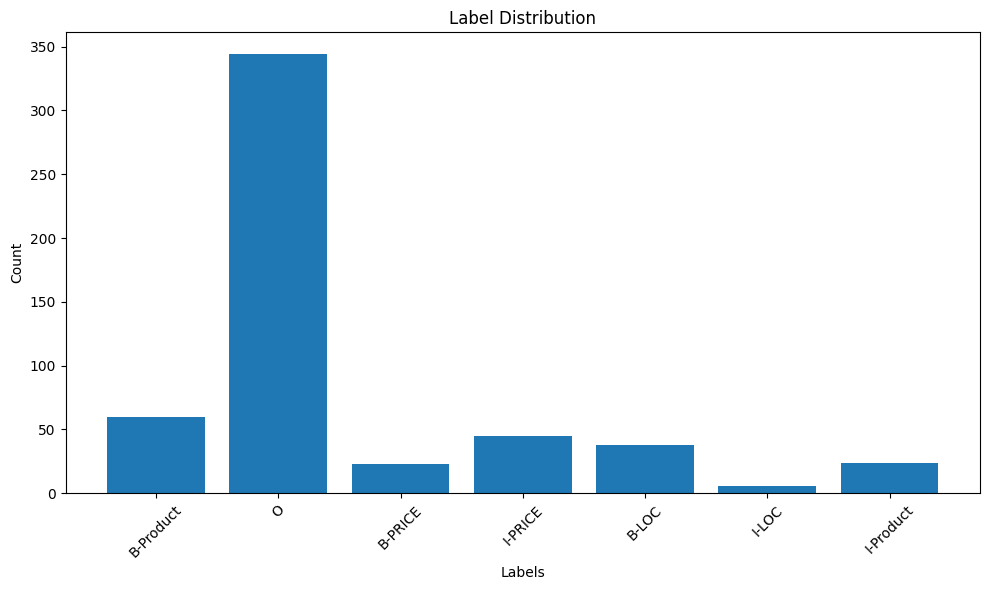


📏 Sentence Length Analysis:
Average: 10.6 tokens
Median: 6.0 tokens
Max: 60 tokens
Min: 4 tokens


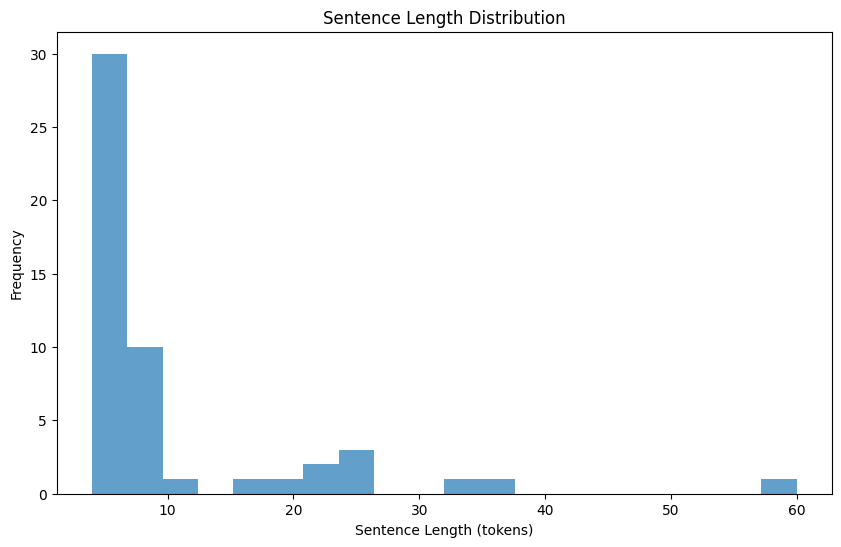

In [13]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

def run_data_diagnostics(conll_file_path):
    """Run comprehensive data diagnostics"""
    print("🔍 Running Data Diagnostics...")
    print("=" * 50)

    sentences = []
    labels = []
    current_sentence = []
    current_labels = []
    skipped_lines = []

    # Load data
    try:
        with open(conll_file_path, 'r', encoding='utf-8') as f:
            content = f.read().strip()
            # Split on double newlines
            messages = [msg.strip() for msg in content.split('\n\n') if msg.strip()]

            print(f"Found {len(messages)} raw messages")

            for msg_num, msg in enumerate(messages, 1):
                lines = [line.strip() for line in msg.split('\n') if line.strip()]
                is_valid = True
                current_sentence = []
                current_labels = []

                for line_num, line in enumerate(lines, 1):
                    # Split on whitespace - handle both spaces and tabs
                    parts = line.split()
                    if len(parts) < 2:
                        skipped_lines.append((msg_num, line_num, line))
                        is_valid = False
                        continue

                    # Get token and label
                    token = ' '.join(parts[:-1])  # Everything except last part
                    label = parts[-1]

                    # Fix common label issues
                    if label in ['B-ORG', 'I-ORG']:
                        label = label.replace('ORG', 'LOC')

                    valid_labels = ['O', 'B-Product', 'I-Product', 'B-LOC', 'I-LOC', 'B-PRICE', 'I-PRICE']
                    if label not in valid_labels:
                        skipped_lines.append((msg_num, line_num, line))
                        is_valid = False
                        continue

                    current_sentence.append(token)
                    current_labels.append(label)

                if is_valid and current_sentence:
                    sentences.append(current_sentence)
                    labels.append(current_labels)
                elif current_sentence:
                    print(f"⚠️ Skipping invalid message {msg_num}")
    except FileNotFoundError:
        print(f"❌ Error: File not found at {conll_file_path}")
        return [], [], {} # Return empty lists/dict on error


    # Report skipped lines
    if skipped_lines:
        print(f"\n⚠️ Skipped {len(skipped_lines)} lines:")
        for msg_num, line_num, line in skipped_lines[:5]:
            print(f"  Message {msg_num}, Line {line_num}: '{line}'")
        if len(skipped_lines) > 5:
            print(f"  ...and {len(skipped_lines) - 5} more skipped lines")

    print(f"\n✅ Loaded {len(sentences)} sentences")

    # Analyze label distribution
    all_labels = [label for sentence_labels in labels for label in sentence_labels]
    label_counts = Counter(all_labels)

    print(f"\n📊 Label Distribution:")
    print(f"Total tokens: {len(all_labels)}")
    print(f"Unique labels: {len(label_counts)}")

    total_tokens = len(all_labels)
    for label, count in label_counts.most_common():
        percentage = (count / total_tokens) * 100 if total_tokens > 0 else 0
        print(f"  {label}: {count} ({percentage:.1f}%)")

    # Check class imbalance
    o_percentage = (label_counts.get('O', 0) / total_tokens) * 100 if total_tokens > 0 else 0
    if o_percentage > 90:
        print(f"\n⚠️ SEVERE CLASS IMBALANCE: {o_percentage:.1f}% of tokens are 'O'")

    # Plot distribution
    plt.figure(figsize=(10, 6))
    labels_list = list(label_counts.keys())
    counts_list = list(label_counts.values())

    plt.bar(labels_list, counts_list)
    plt.title('Label Distribution')
    plt.xlabel('Labels')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Sentence length analysis
    lengths = [len(sentence) for sentence in sentences]
    if lengths:
        print(f"\n📏 Sentence Length Analysis:")
        print(f"Average: {np.mean(lengths):.1f} tokens")
        print(f"Median: {np.median(lengths):.1f} tokens")
        print(f"Max: {max(lengths)} tokens")
        print(f"Min: {min(lengths)} tokens")

        plt.figure(figsize=(10, 6))
        plt.hist(lengths, bins=20, alpha=0.7)
        plt.title('Sentence Length Distribution')
        plt.xlabel('Sentence Length (tokens)')
        plt.ylabel('Frequency')
        plt.show()

    return sentences, labels, label_counts

# Run diagnostics
sentences, labels, label_counts = run_data_diagnostics('/content/amharic_ner_conll_100 (1).txt')

In [14]:
class AmharicNERTrainer:
    def __init__(self, model_name="xlm-roberta-base"):
        """Initialize the NER trainer"""
        # Define label mapping
        self.label_list = ["O", "B-Product", "I-Product", "B-LOC", "I-LOC", "B-PRICE", "I-PRICE"]
        self.label_to_id = {label: i for i, label in enumerate(self.label_list)}
        self.id_to_label = {i: label for label, i in self.label_to_id.items()}

        print(f"Label mapping: {self.label_to_id}")

        # Load tokenizer and model
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModelForTokenClassification.from_pretrained(
            model_name,
            num_labels=len(self.label_list),
            id2label=self.id_to_label,
            label2id=self.label_to_id
        )

    def tokenize_and_align_labels(self, sentences, labels):
        """Tokenize sentences and align labels"""
        tokenized_inputs = []

        for sentence, sentence_labels in zip(sentences, labels):
            tokenized = self.tokenizer(
                sentence,
                truncation=True,
                padding=False,
                max_length=128,
                is_split_into_words=True,
                return_offsets_mapping=True
            )

            word_ids = tokenized.word_ids()
            aligned_labels = []
            previous_word_idx = None

            for word_idx in word_ids:
                if word_idx is None:
                    aligned_labels.append(-100)
                elif word_idx != previous_word_idx:
                    if word_idx < len(sentence_labels):
                        aligned_labels.append(self.label_to_id[sentence_labels[word_idx]])
                    else:
                        aligned_labels.append(self.label_to_id['O'])
                else:
                    aligned_labels.append(-100)
                previous_word_idx = word_idx

            tokenized.pop('offset_mapping', None)
            tokenized['labels'] = aligned_labels
            tokenized_inputs.append(tokenized)

        return tokenized_inputs

    def create_dataset(self, tokenized_inputs):
        """Create HuggingFace dataset"""
        dataset_dict = {
            'input_ids': [item['input_ids'] for item in tokenized_inputs],
            'attention_mask': [item['attention_mask'] for item in tokenized_inputs],
            'labels': [item['labels'] for item in tokenized_inputs]
        }
        return Dataset.from_dict(dataset_dict)

    def compute_metrics(self, eval_pred):
        """Compute evaluation metrics"""
        predictions, labels = eval_pred
        predictions = np.argmax(predictions, axis=2)

        true_predictions = [
            [self.id_to_label[p] for (p, l) in zip(prediction, label) if l != -100]
            for prediction, label in zip(predictions, labels)
        ]
        true_labels = [
            [self.id_to_label[l] for (p, l) in zip(prediction, label) if l != -100]
            for prediction, label in zip(predictions, labels)
        ]

        flat_true_labels = [label for sentence in true_labels for label in sentence]
        flat_predictions = [pred for sentence in true_predictions for pred in sentence]

        accuracy = accuracy_score(flat_true_labels, flat_predictions)
        report = classification_report(flat_true_labels, flat_predictions, output_dict=True, zero_division=0)

        return {
            'accuracy': accuracy,
            'f1': report['macro avg']['f1-score'],
            'precision': report['macro avg']['precision'],
            'recall': report['macro avg']['recall']
        }

In [15]:
# Initialize trainer
trainer = AmharicNERTrainer("xlm-roberta-base")

# Split data (80% train, 20% validation)
split_idx = int(0.8 * len(sentences))
train_sentences = sentences[:split_idx]
train_labels = labels[:split_idx]
val_sentences = sentences[split_idx:]
val_labels = labels[split_idx:]

print(f"Training set: {len(train_sentences)} sentences")
print(f"Validation set: {len(val_sentences)} sentences")

# Tokenize and align labels
print("Tokenizing and aligning labels...")
train_tokenized = trainer.tokenize_and_align_labels(train_sentences, train_labels)
val_tokenized = trainer.tokenize_and_align_labels(val_sentences, val_labels)

# Create datasets
train_dataset = trainer.create_dataset(train_tokenized)
val_dataset = trainer.create_dataset(val_tokenized)

print("✅ Data preparation complete!")


Label mapping: {'O': 0, 'B-Product': 1, 'I-Product': 2, 'B-LOC': 3, 'I-LOC': 4, 'B-PRICE': 5, 'I-PRICE': 6}


Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training set: 40 sentences
Validation set: 11 sentences
Tokenizing and aligning labels...
✅ Data preparation complete!


In [16]:
# Calculate class weights to handle imbalance
total_tokens = sum(label_counts.values())
o_percentage = (label_counts.get('O', 0) / total_tokens) * 100

print(f"Class imbalance: {o_percentage:.1f}% are 'O' labels")

# Configure training arguments
output_dir = "./amharic_ner_model"

training_args = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=15,  # Increased epochs
    per_device_train_batch_size=4,  # Smaller batch size
    per_device_eval_batch_size=4,
    warmup_steps=100,
    weight_decay=0.01,
    logging_dir=f'{output_dir}/logs',
    logging_steps=10,
    eval_strategy="steps",
    eval_steps=50,
    save_strategy="steps",
    save_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    learning_rate=1e-5,  # Lower learning rate
    lr_scheduler_type="linear",
    remove_unused_columns=False,
    push_to_hub=False,
    report_to="none",  # Disable reporting to wandb
    fp16=True,  # Enable mixed precision if GPU supports it
)

print("✅ Training configuration set!")

Class imbalance: 63.7% are 'O' labels
✅ Training configuration set!


In [17]:
from transformers import DataCollatorForTokenClassification

# Data collator
data_collator = DataCollatorForTokenClassification(
    tokenizer=trainer.tokenizer,
    padding=True
)

# Initialize Trainer
model_trainer = Trainer(
    model=trainer.model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=trainer.tokenizer,
    data_collator=data_collator,
    compute_metrics=trainer.compute_metrics,
)

# Start training
print("🚀 Starting training...")
print("This may take 10-30 minutes depending on your GPU...")

model_trainer.train()

# Save the model
model_trainer.save_model(output_dir)
trainer.tokenizer.save_pretrained(output_dir)

print("✅ Training complete! Model saved.")

🚀 Starting training...
This may take 10-30 minutes depending on your GPU...


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
50,1.725000,1.775274,0.200000,0.091459,0.068254,0.153509
100,0.781600,1.130110,0.476923,0.244322,0.204949,0.333333
150,0.455600,0.549185,0.892308,0.778025,0.780513,0.783333


✅ Training complete! Model saved.


In [18]:
def test_model(text_input, model_path="./amharic_ner_model"):
    """Test the trained model"""
    # Load the trained model
    model = AutoModelForTokenClassification.from_pretrained(model_path)
    tokenizer = AutoTokenizer.from_pretrained(model_path)

    # Tokenize
    tokens = text_input.split()
    tokenized = tokenizer(
        tokens,
        truncation=True,
        padding=True,
        max_length=128,
        is_split_into_words=True,
        return_tensors="pt"
    )

    # Predict
    with torch.no_grad():
        outputs = model(**tokenized)
        predictions = torch.argmax(outputs.logits, dim=2)

    # Get label mapping
    id_to_label = model.config.id2label

    # Align predictions with tokens
    word_ids = tokenized.word_ids()
    predicted_labels = []

    for i, word_id in enumerate(word_ids):
        if word_id is not None and (i == 0 or word_ids[i-1] != word_id):
            predicted_labels.append(id_to_label[predictions[0][i].item()])

    return list(zip(tokens, predicted_labels))

# Test with sample texts
test_texts = [
    "NIKE ጫማ ዋጋ 1000 ብር አዲስ አበባ",
    "ADIDAS ሻንፖ ቦርሳ ፒያሳ መርካቶ 500 ብር",
    "ልብስ ሸሚዝ ዋጋ 800 ብር ቄራ ሶፊያ ሞል"
]

print("🧪 Testing the trained model:")
print("=" * 50)

for i, text in enumerate(test_texts, 1):
    print(f"\nTest {i}: {text}")
    predictions = test_model(text)
    print("Predictions:")
    for token, label in predictions:
        print(f"  {token:15} -> {label}")

🧪 Testing the trained model:

Test 1: NIKE ጫማ ዋጋ 1000 ብር አዲስ አበባ
Predictions:
  NIKE            -> B-Product
  ጫማ              -> B-Product
  ዋጋ              -> B-PRICE
  1000            -> I-PRICE
  ብር              -> I-PRICE
  አዲስ             -> O
  አበባ             -> O

Test 2: ADIDAS ሻንፖ ቦርሳ ፒያሳ መርካቶ 500 ብር
Predictions:
  ADIDAS          -> O
  ሻንፖ             -> O
  ቦርሳ             -> O
  ፒያሳ             -> O
  መርካቶ            -> B-Product
  500             -> I-PRICE
  ብር              -> I-PRICE

Test 3: ልብስ ሸሚዝ ዋጋ 800 ብር ቄራ ሶፊያ ሞል
Predictions:
  ልብስ             -> B-Product
  ሸሚዝ             -> B-Product
  ዋጋ              -> B-PRICE
  800             -> I-PRICE
  ብር              -> I-PRICE
  ቄራ              -> B-Product
  ሶፊያ             -> B-LOC
  ሞል              -> O


In [11]:
import os
print(os.listdir('/content/'))

['.config', '.ipynb_checkpoints', 'amharic_ner_model', 'amharic_ner_conll_100 (1).txt', 'sample_data']
